## Problem Set 6
## MACS 40000
## Problem 1(A)

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy.optimize as opt
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_main = pd.read_stata('p13i6.dta')
df_summ = pd.read_stata('rscfp2013.dta')
df = pd.concat([df_main, df_summ], axis = 1)

In [3]:
# Keep the variables that we need
df = df[['X5804', 'X5809', 'X5814', 'X5805', 'X5810', 'X5815', 'X8022', 'networth', 'wgt']]

In [4]:
# Replace the bequests received before 2011 by 0 and multiply by inflation index 
df.loc[df.X5805 < 2011, 'X5804'] = 0
df.loc[df.X5810 < 2011, 'X5809'] = 0
df.loc[df.X5815 < 2011, 'X5814'] = 0

df.loc[df.X5805 == 2011, 'X5804'] = 0.9652 * df.loc[df.X5805 == 2011, 'X5804']
df.loc[df.X5805 == 2012, 'X5804'] = 0.9854 * df.loc[df.X5805 == 2012, 'X5804']
df.loc[df.X5810 == 2011, 'X5809'] = 0.9652 * df.loc[df.X5810 == 2011, 'X5809']
df.loc[df.X5810 == 2012, 'X5809'] = 0.9854 * df.loc[df.X5810 == 2012, 'X5809']
df.loc[df.X5815 == 2011, 'X5814'] = 0.9652 * df.loc[df.X5805 == 2011, 'X5814']
df.loc[df.X5815 == 2012, 'X5814'] = 0.9854 * df.loc[df.X5805 == 2012, 'X5814']

In [5]:
# Multiply by weight
df[['X5804', 'X5809', 'X5814']].multiply(df['wgt'], axis="index")

# Calculate age at which bequests are received
df['age_1'] = df['X8022'] - (2013 - df['X5805'])
df['age_2'] = df['X8022'] - (2013 - df['X5810'])
df['age_3'] = df['X8022'] - (2013 - df['X5815'])
df.loc[df.age_1 < 21, 'X5804'] = 0
df.loc[df.age_2 < 21, 'X5809'] = 0
df.loc[df.age_2 < 21, 'X5814'] = 0

In [6]:
# Calculate total bequests by age
bq_tot = np.zeros(80)
for i in range(21, 101):
    bq_tot[i - 21] = df.loc[df['X8022'] == i, 'X5804'].sum() + df.loc[df['X8022'] == i, 'X5809'].sum() + \
                       df.loc[df['X8022'] == i, 'X5814'].sum()
bq_tot /= bq_tot.sum()

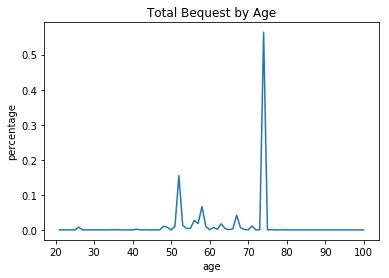

In [7]:
plt.plot(np.arange(21, 101), bq_tot)
plt.title("Total Bequest by Age")
plt.xlabel("age")
plt.ylabel("percentage")
plt.show()

## Problem 1(b)

In [8]:
# Generate income groups
income = df['networth']
df['inc_pct'] = df.networth.rank(pct = True)
df.loc[df.inc_pct <= 0.25, 'inc_group'] = 1
df.loc[(df.inc_pct > 0.25) & (df.inc_pct <= 0.5), 'inc_group'] = 2
df.loc[(df.inc_pct > 0.50) & (df.inc_pct <= 0.75), 'inc_group'] = 3
df.loc[df.inc_pct > 0.75, 'inc_group'] = 4

In [9]:
bq_tot_1 = np.zeros((80, 4))
for i in range(21, 101):
    for j in range(1, 5):
        bq_tot_1[i - 21, j - 1] = df.loc[(df['X8022'] == i) & (df['inc_group'] == j), 'X5804'].sum() + \
                                df.loc[(df['X8022'] == i) & (df['inc_group'] == j), 'X5809'].sum() + \
                                df.loc[(df['X8022'] == i) & (df['inc_group'] == j), 'X5814'].sum()
bq_tot_1 /= bq_tot_1.sum()

<IPython.core.display.Javascript object>


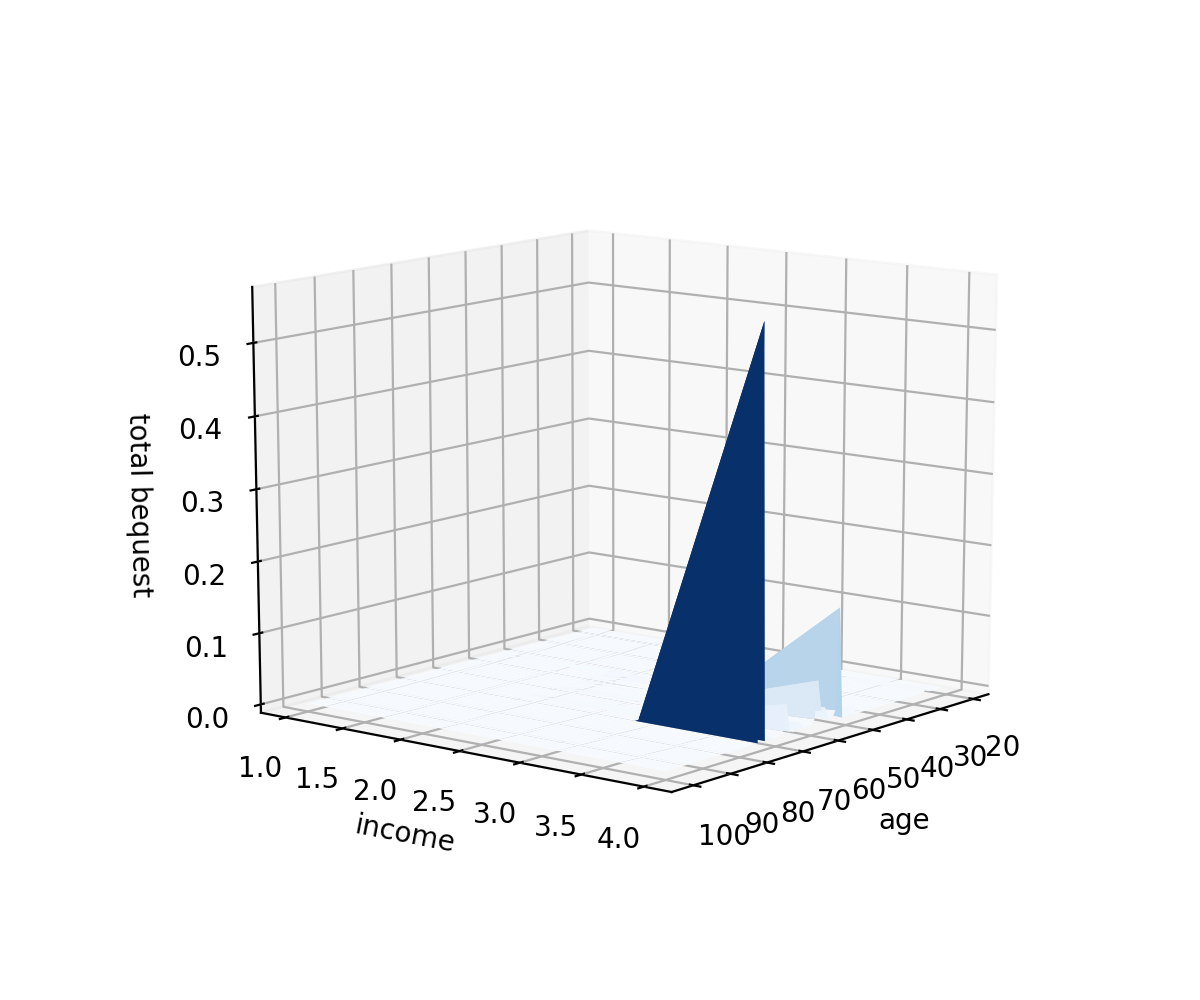

In [10]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook
fig = plt.figure(figsize=(6, 5))
age, inc = np.meshgrid(np.arange(21, 101), np.arange(1, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(age, inc, bq_tot_1.T, rstride=1, cstride=1, cmap=cm.Blues)
ax.view_init(elev=20., azim=20)  
ax.set_xlabel(r'age')
ax.set_ylabel(r'income')
ax.set_zlabel(r'total bequest')
plt.show()

## Problem 2(a) & (b)

In [11]:
# Household Parameters
yrs_live = 80
S = 80
beta_annual = .96
beta = beta_annual ** (yrs_live / S)
sigma = 2.2
nvec = np.ones(S)
cut = round(2 * S / 3)
nvec[cut: ] = 0.2
chi_vec_bq = np.ones(S)

# Firm Parameters
alpha = 0.35
A = 1.0
delta_annual = 0.05
delta = 1- ((1 - delta_annual) ** (yrs_live / S))

# Define functions for calculating L, K, w, r, Y

def get_L(nvec): # function for aggregate labor
    L = nvec.sum()
    return L

def get_K(bvec): # function for aggregate capital
    K = bvec.sum()
    return K

def get_w(K, L, params): # function for wage
    A, alpha = params
    w = (1 - alpha) * A * ((K / L) ** alpha)
    return w

def get_r(K, L, params): # function for interest rate
    A, alpha, delta = params
    r = alpha * A * ((L / K) ** (1 - alpha)) - delta
    return r

def get_Y(K, L, params): # function for output
    A, alpha = params
    Y = A * (K ** alpha) * (L ** (1 - alpha))
    return Y


 Savings: 			 [0.04, 0.09, 0.14, 0.19, 0.25, 0.32, 0.39, 0.47, 0.55, 0.63, 0.73, 0.82, 0.93, 1.04, 1.15, 1.28, 1.41, 1.55, 1.69, 1.85, 2.01, 2.18, 2.36, 2.55, 2.75, 2.96, 3.18, 3.42, 3.67, 3.92, 4.2, 4.66, 4.97, 5.28, 5.61, 5.99, 6.36, 6.81, 7.22, 7.63, 8.06, 8.51, 8.99, 9.48, 9.99, 10.52, 11.12, 11.7, 12.3, 12.92, 13.58, 14.25, 14.95, 15.25, 14.89, 14.53, 14.15, 13.76, 13.36, 12.94, 12.52, 12.07, 11.62, 11.15, 10.66, 10.16, 9.65, 9.11, 8.56, 7.99, 7.4, 6.8, 6.17, 5.52, 4.85, 4.16, 3.44, 2.7, 1.93, 1.14] 
 Capital and Labor: 		 [ 496.09   58.4 ] 
 Wage and Interest rate: 	 [ 1.37  0.04] 
 Consumption: 			 [1.33, 1.33, 1.33, 1.32, 1.32, 1.32, 1.32, 1.31, 1.31, 1.31, 1.31, 1.3, 1.3, 1.3, 1.3, 1.29, 1.29, 1.29, 1.29, 1.28, 1.28, 1.28, 1.28, 1.27, 1.27, 1.27, 1.27, 1.26, 1.26, 1.26, 1.26, 1.25, 1.25, 1.25, 1.25, 1.24, 1.24, 1.24, 1.24, 1.23, 1.23, 1.23, 1.23, 1.22, 1.22, 1.22, 1.22, 1.21, 1.21, 1.21, 1.21, 1.2, 1.2, 1.2, 1.2, 1.19, 1.19, 1.19, 1.19, 1.19, 1.18, 1.18, 1.18, 1.18, 1.17, 1.1

<IPython.core.display.Javascript object>


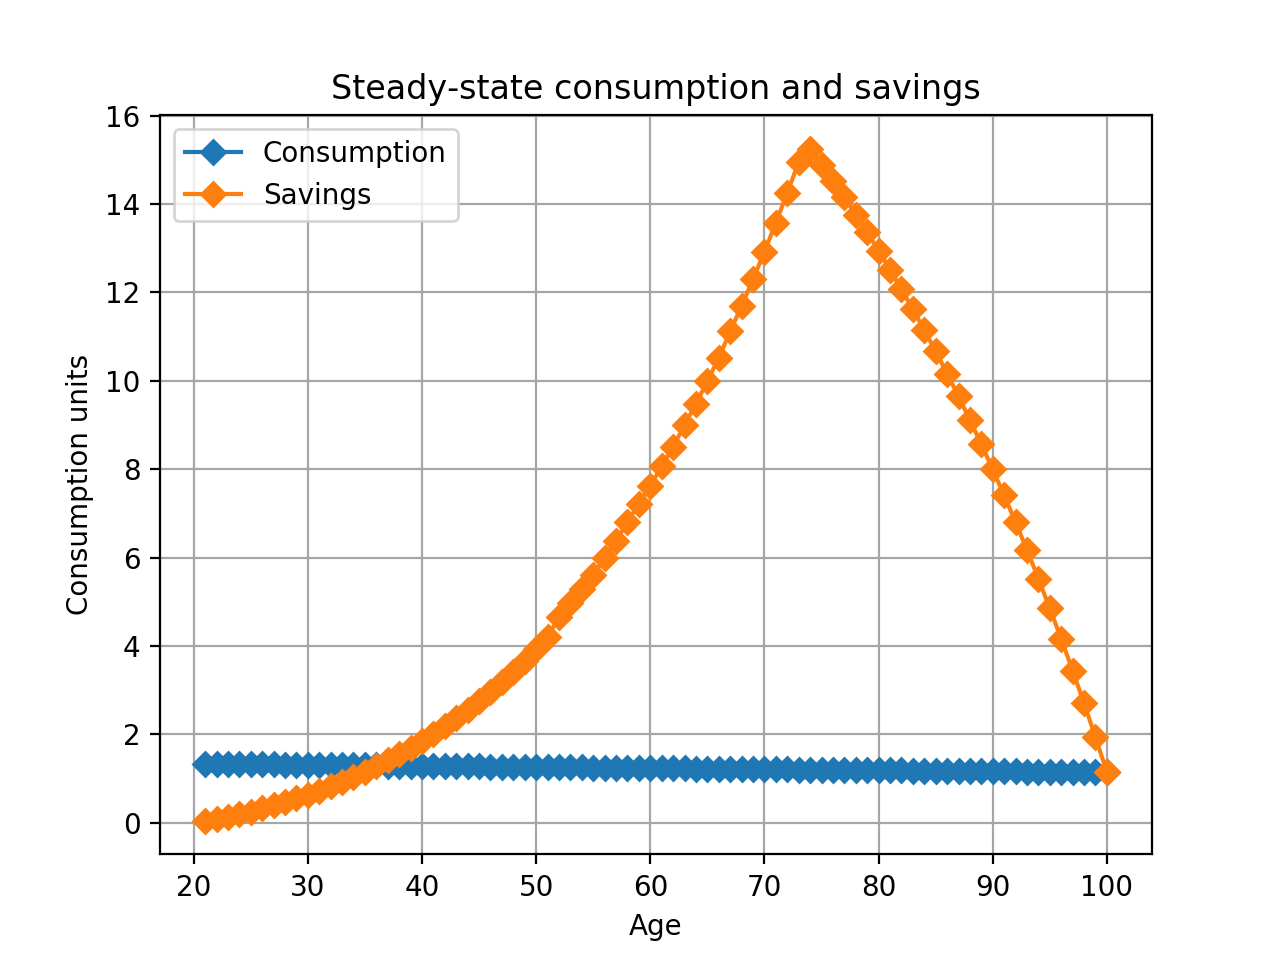

In [12]:
def errors(bvec, *args):

    A, alpha, delta, nvec, beta, sigma, chi_vec_bq, bq_tot = args
    L = get_L(nvec)
    K = get_K(bvec)
    w = get_w(K, L, (A, alpha))
    r = get_r(K, L, (A, alpha, delta))
    
    BQ = (1 + r) * bvec[-1]
    b = np.append([0], bvec[:-1])
    cvec = (1 + r) * b + w * nvec + bq_tot * BQ - bvec

    muc = cvec ** (-sigma)

    berr_ss = muc[:-1] - beta * (1 + r) * muc[1:]
    cerr_ss = chi_vec_bq[-1] * (bvec[-1]) ** (-sigma)- \
              ((1 + r) * bvec[-2] + w * nvec[-1] + bq_tot[-1] * BQ - bvec[-1]) ** (-sigma)
    EulErr_ss = np.hstack((berr_ss, cerr_ss))
    
    return EulErr_ss

def get_SS(params, bvec_guess, SS_graphs = False):

    start_time = time.clock()

    A, alpha, delta, nvec, beta, sigma, chi_vec_bq, bq_tot = params

    b = opt.root(errors, bvec_guess, args = (A, alpha, delta, nvec, beta, sigma, chi_vec_bq, bq_tot), tol = SS_tol)
    if b.success:
        b_ss = b.x
    else:
        raise ValueError("Failed to find b_ss")

    K_ss = get_K(b_ss)
    L = get_L(nvec)
    w_ss = get_w(K_ss, L, (A, alpha))
    r_ss = get_r(K_ss, L, (A, alpha, delta))
    Y_ss = get_Y(K_ss, L, (A, alpha))

    BQ_ss = (1 + r_ss) * b_ss[-1]
    b = np.append([0], b_ss[:-1])
    c_ss = (1 + r_ss) * b + w_ss * nvec + bq_tot * BQ_ss - b_ss
    C_ss = c_ss.sum()
    
    muc = c_ss ** (-sigma)
    EulErr_ss = muc[:-1] - beta * (1 + r_ss) * muc[1:]

    RCerr_ss = Y_ss - C_ss - delta * K_ss

    ss_time = time.clock() - start_time

    ss_output = {
        'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss,
        'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss, 'BQ_ss': BQ_ss,
        'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
        'ss_time': ss_time}

    b = [float(i) for i in ["%.2f" % v for v in b_ss]]
    K = float("{0:.2f}".format(K_ss))
    w = float("{0:.2f}".format(w_ss))
    r = float("{0:.2f}".format(r_ss))
    c = [float(i) for i in ["%.2f" % v for v in c_ss]]

    print('\n Savings: \t\t\t {} \n Capital and Labor: \t\t {} \n Wage and Interest rate: \t {} \n Consumption: \t\t\t {}'.format(b, np.array([K, L]), np.array([w, r]), c))
    print('Bequest:  ', BQ_ss)
    print('Euler errors: ', EulErr_ss)
    print('Resource Constraint error: ', RCerr_ss)
    print('Time needed: ', ss_time)

    if SS_graphs:
        age = np.arange(21, S + 21)
        fig, ax = plt.subplots()
        plt.plot(age, c_ss, marker='D',label='Consumption')
        plt.plot(age, b_ss, marker = 'D', label='Savings')
        plt.grid(b=True, which='major', color='0.65', linestyle='-')
        plt.title('Steady-state consumption and savings')
        plt.xlabel('Age')
        plt.ylabel('Consumption units')
        plt.legend()
        plt.show()

    return ss_output

L_ss = get_L(nvec)
SS_tol = 1e-9

params = (A, alpha, delta, nvec, beta, sigma, chi_vec_bq, bq_tot)
bvec_guess = np.ones(S) * 0.1
SS = get_SS(params, bvec_guess, SS_graphs = True)

## Problem 3(a)

In [13]:
# TPI params
T = 300
max_iter = 300
tol = 1e-12
xi = 0.4
b_ss = SS['b_ss']
K_ss = SS['K_ss']
w_ss = SS['w_ss']
r_ss = SS['r_ss']
BQ_ss = SS['BQ_ss']

# Initial guess for capital stock
weights = ((1.5 - 0.87) / 78) * (np.arange(S) - 1) + 0.87
b1vec = weights * b_ss
K1 = get_K(b1vec)
Kpath_old = np.zeros(T + S - 1)
Kpath_old[:T] = np.linspace(K1, K_ss, T) # Until reaching steady state
Kpath_old[T:] = K_ss
r = get_r(Kpath_old[0], L_ss, (A, alpha, delta))
BQ1 = (1 + r) * b1vec[-1]
BQpath_old = np.zeros(T + S - 1)
BQpath_old[:T] = np.linspace(BQ1, BQ_ss, T) # Until reaching steady state
BQpath_old[T:] = BQ_ss
    
'''Calculate lifetime euler function error. Remaining lifetime can be of varying length p.
bvec is of length p-1.
'''
def get_errors(bvec, *args):
    beg_wealth, nvec, beta, sigma, w_path, r_path, BQ, chi_vec_bq, bq_tot = args
    b = np.append(beg_wealth, bvec)
    c = (1 + r_path) * b[:-1] + w_path * nvec + bq_tot * BQ - bvec
    muc = c ** (-sigma)
    berr_ss = muc[:-1] - beta * (1 + r_path[1:]) * muc[1:]
    cerr_ss = chi_vec_bq[-1] * (b[-1]) ** (-sigma)- \
              ((1 + r_path[-1]) * b[-2] + w_path[-1] * nvec[-1] + bq_tot[-1] * BQ[-1] - b[-1]) ** (-sigma)
    EulErr_ss = np.hstack((berr_ss, cerr_ss))
    return EulErr_ss

In [14]:
abs2 = 1
tpi_iter = 0

while abs2 > tol and tpi_iter < max_iter:
    tpi_iter = tpi_iter + 1
    r_path = get_r(Kpath_old, L_ss, (A, alpha, delta))
    w_path = get_w(Kpath_old, L_ss, (A, alpha))
    
    # Initialize savings matrix
    b = np.zeros((S, T + S - 1))
    b[:, 0] = b1vec
    
    # Solve the incomplete remaining lifetime decisions of agents alive
    # in period t=1 but not born in period t=1
    for p in range(1, S):
        bvec_guess = np.diagonal(b[S - p:, :p])
        beg_wealth = b[S - p - 1, 0]
        args_bp = (beg_wealth, nvec[-p:], beta, sigma, w_path[:p], r_path[:p], BQpath_old[:p], chi_vec_bq[-p:], bq_tot[-p:])
        bp = opt.root(get_errors, bvec_guess, args = (args_bp)).x
    # Insert the vector lifetime solutions diagonally (twist donut)
        DiagMaskbp = np.eye(p)
        bp_path = DiagMaskbp * bp
        b[S - p:, 1:p + 1] += bp_path

    # Solve for complete lifetime decisions of agents born in periods
    # 1 to T
    for t in range(1, T):
        bvec_guess = np.diagonal(b[:, t - 1:S + t - 1])
        args_bt = (0, nvec, beta, sigma, w_path[t - 1 : S + t - 1], r_path[t - 1 : S + t - 1], BQpath_old[t - 1 : S + t - 1], chi_vec_bq, bq_tot)
        bt = opt.root(get_errors, bvec_guess, args = (args_bt)).x
        DiagMaskbt = np.eye(S)
        bt_path = DiagMaskbt * bt
        b[:, t: S + t] += bt_path

    # Calculate the implied capital stock from conjecture and the error
    Kpath_new = b.sum(axis = 0)
    BQpath_new = (1 + r_path) * b[S - 1, :]
    abs2 = (((Kpath_old[:T] - Kpath_new[:T])/Kpath_old[:T] * 100) ** 2).sum()+\
           (((BQpath_old[:T] - BQpath_new[:T])/BQpath_old[:T] * 100)** 2).sum()
    
    # Update guess
    Kpath_old[:T] = xi * Kpath_new[:T] + (1 - xi) * Kpath_old[:T]
    BQpath_old[:T] = xi * BQpath_new[:T] + (1 - xi) * BQpath_old[:T]
    print('iteration:', tpi_iter, ' squared distance: ', abs2)

iteration: 1  squared distance:  426442.59737
iteration: 2  squared distance:  46214.971028
iteration: 3  squared distance:  7546.33691936
iteration: 4  squared distance:  2084.26653801
iteration: 5  squared distance:  693.591485329
iteration: 6  squared distance:  245.22493223
iteration: 7  squared distance:  88.6927969551
iteration: 8  squared distance:  32.4203933026
iteration: 9  squared distance:  11.9228717222
iteration: 10  squared distance:  4.4022169492
iteration: 11  squared distance:  1.63003528306
iteration: 12  squared distance:  0.604857561917
iteration: 13  squared distance:  0.224819986303
iteration: 14  squared distance:  0.0836750981894
iteration: 15  squared distance:  0.0311765760751
iteration: 16  squared distance:  0.0116264843938
iteration: 17  squared distance:  0.00433901739775
iteration: 18  squared distance:  0.00162033934206
iteration: 19  squared distance:  0.000605411892553
iteration: 20  squared distance:  0.000226304341957
iteration: 21  squared distance

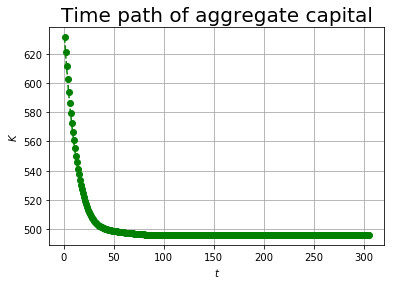

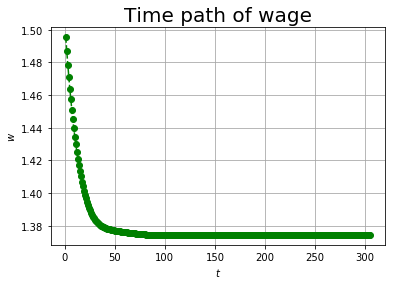

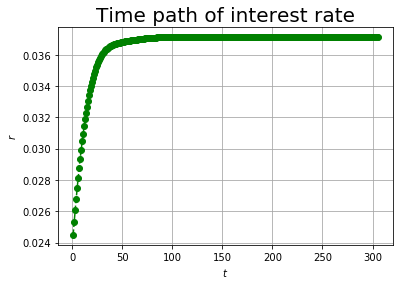

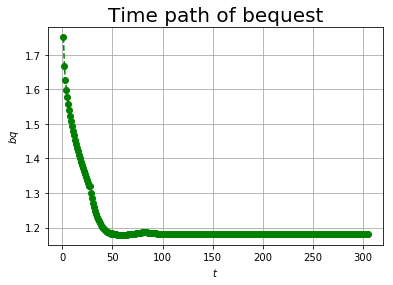

In [15]:
%matplotlib inline
plt.plot(1 + np.arange(T + 5), np.append(Kpath_old[:T-2], K_ss * np.ones(7)), 'go--')
plt.grid(b=True, which='major', color='0.65', linestyle='-')
plt.title('Time path of aggregate capital', fontsize=20)
plt.xlabel(r'$t$')
plt.ylabel(r'$K$')
plt.show()

w_path = get_w(Kpath_old, L_ss, (A, alpha))
r_path = get_r(Kpath_old, L_ss, (A, alpha, delta))

plt.plot(1 + np.arange(T + 5), np.append(w_path[:T-2], w_ss * np.ones(7)), 'go--')
plt.grid(b=True, which='major', color='0.65', linestyle='-')
plt.title('Time path of wage', fontsize=20)
plt.xlabel(r'$t$')
plt.ylabel(r'$w$')
plt.show()

plt.plot(1 + np.arange(T + 5), np.append(r_path[:T-2], r_ss * np.ones(7)), 'go--')
plt.grid(b=True, which='major', color='0.65', linestyle='-')
plt.title('Time path of interest rate', fontsize=20)
plt.xlabel(r'$t$')
plt.ylabel(r'$r$')
plt.show()

plt.plot(1 + np.arange(T + 5), np.append(BQpath_old[:T-2], BQ_ss * np.ones(7)), 'go--')
plt.grid(b=True, which='major', color='0.65', linestyle='-')
plt.title('Time path of bequest', fontsize=20)
plt.xlabel(r'$t$')
plt.ylabel(r'$bq$')
plt.show()

## Problem 3(b)

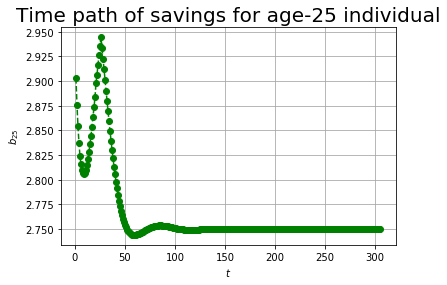

In [16]:
b25 = b[24, :]
plt.plot(1 + np.arange(T + 5), np.append(b25[:T-2], b_ss[24] * np.ones(7)), 'go--')
plt.grid(b=True, which='major', color='0.65', linestyle='-')
plt.title('Time path of savings for age-25 individual', fontsize=20)
plt.xlabel(r'$t$')
plt.ylabel(r'$b_{25}$')
plt.show()